# Стохастический градиентный и координатный спуски

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

main_df = pd.read_csv('Advertising.csv')
main_df.drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
main_df.info() # нет пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
X = main_df.values[:, :3]
y = main_df.values[:, 3]
y = y.reshape(-1, 1)

## Координатный спуск

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [4]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные**

In [5]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Задано:**

* $X=(x_{ij})$ - матрица наблюдений, размерностью $dim(X)=(m, n)$
* $N=1000$ - количество итераций


**Алгоритм (математическая запись):**
* Создать нулевой вектор параметров $w_0=(0, 0,..., 0)^T$
* Для всех $t=1, 2, ..., N$ итераций:
    * Для всех $k = 1, 2,..., n$:
        * Фиксируем значение всех признаков, кроме $k$-ого и вычисляем прогноз модели линейной регрессии.Для этого исключаем признак $k$-ый из данных и $w_j$ из параметров при построении прогноза.
        Математически это можно записать следующим образом:

        $$h_i = \sum_{j=1}^{k-1} x_{ij}w_{j} + \sum_{j=k+1}^{n} x_{ij}w_j $$

        **Примечание:**
        
        *Обратите, что в данной записи текущий признак под номером $k$ не участвует в сумме.Сравните эту запись с классической записью прогноза линейной регрессии в случае нормированных данных (когда участвуют все признаки):*

        $$h_i = \sum_{j=1}^{n} x_{ij}w_{j}$$ 
        
        * Вычисляем новое значение параметра $k$-ого коэффициента: 
        $$w_k = \sum_{i=1}^{m} x_{ik} (y_i - h_i) = x_k^T(y-h) $$

    * Вычисляем значение функции потерь и сохраняем в историю изменения функции потерь (В оценке функции потерь участвуют все признаки):
        $$\hat{y_i} = \sum_{j=1}^{n}x_{ij}w_j$$
        $$Loss_t = \frac{1}{n} \sum_{i=1}^{m}(y_i-\hat{y_i})^2$$
        
        или в векторном виде:
        
        $$\hat{y} = Xw$$
        $$Loss_t = \frac{1}{n}(y-\hat{y})^T(y-\hat{y})$$
    



**Алгоритм (псевдокод):**
```python

num_iters = #количество итераций
m = # количество строк в матрице X
n = # количество столбцов в матрице X
w = #вектор размера nx1, состояющий из нулей

for i in range(num_iters):
    for k in range(n):
        # Вычисляем прогноз без k-ого фактора
        h = (X[:,0:k] @ w[0:k]) + (X[:,k+1:] @ w[k+1:])
        # Обновляем новое значение k-ого коэффициента
        w[k] =  (X[:,k].T @ (y - h))
        # Вычисляем функцию потерь
        cost = sum((X @ w) - y) ** 2)/(len(y))

```

In [6]:
def coordinate_descent(X, y, num_iters=100, tolerance=1e-4):
    m,n = X.shape
    w = np.zeros(4).reshape(-1, 1)
    
    for i in range(num_iters):
        w_init = w.copy()
        for j in range(n):
            h = (X[:, 0:j] @ w[0:j]) + (X[:, j+1:] @ w[j+1:])
            w[j] = (X[:, j] @ (y - h))
        if max(abs(w_init - w)) < tolerance:
            break
    return w, i

w, iterations = coordinate_descent(X, y, num_iters=100)
mse = ((y - X @ w) ** 2).sum() / 200

print(f'interceptor: {w[0]}, вектор параметров: {w[1:]}')
print(f'За {iterations} итераций ошибка минимизирована до {mse}')

interceptor: [41.56239272], вектор параметров: [[110.13144169]
 [ 73.52855119]
 [ -0.55019976]]
За 50 итераций ошибка минимизирована до 2.7841263145747406


Сравним результаты с реализацией линейной регрессии из библиотеки sklearn:

In [7]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

((y - model.predict(X)) ** 2).sum() / 200

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


np.float64(2.784126314510936)

Они должны практически совпали

## Стохастический градиентный спуск

**Стандартизируем столбцы исходной матрицы *X***

In [8]:
X = main_df[['TV', 'radio', 'newspaper']].values

for i in range(3):
    X[:, i] = (X[:, i] - X[:, i].mean()) / X[:, i].std()

**Добавим единичный столбец**

In [9]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
w = np.zeros(X.shape[1]).reshape(-1, 1)

**Создам функцию mse_error для вычисления среднеквадратичной ошибки**

In [10]:
def find_MSE(y, y_hat, dim):
    return ((y - y_hat) ** 2).sum() / dim

**Сделаем наивный прогноз: предскажем продажи средним значением. После этого рассчитаем среднеквадратичную ошибку для этого прогноза**

In [11]:
mse_for_means = find_MSE(y, y.mean(), X.shape[0])

In [12]:
def lin_pred(X, w):
    return X @ w

**Создам функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска.
Функция принимает на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

In [13]:
def stoch_grad_step(X, w, y, train_ind, eta):
    gradient = 2 * X[train_ind] * ((X[train_ind] @ w) - y[train_ind])
    return (w.reshape(-1) - (eta * gradient)).reshape(-1, 1)

**Создадим функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор записыватся текущее значение среднеквадратичной ошибки. Функция возвращает вектор весов $w$, а также вектор ошибок.**

In [14]:
def stochastic_gradient_descent(X, y, w, eta, max_iters=10 ** 5, tolerance=1e-4):
    mse_log = []
    dist = float('inf')
    iters_counter = 0
    while max_iters and dist > tolerance:
        w0 = w.copy()
        iters_counter += 1
        max_iters -= 1
        train_ind = np.random.randint(X.shape[0])
        w = stoch_grad_step(X, w, y, train_ind, eta)
        mse_log.append(find_MSE(y, X @ w, X.shape[0]))
        dist = np.linalg.norm(w - w0)
    
    return iters_counter, w, mse_log

**Построим график зависимости ошибки от номера итерации**

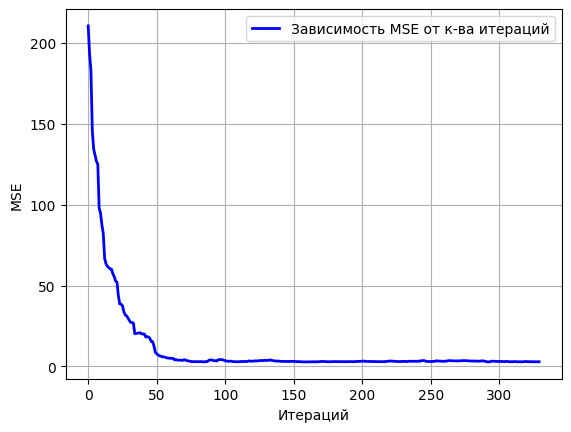

In [15]:
iterss, w_pred, mse = stochastic_gradient_descent(X, y, w, 0.02)


plt.plot(mse, label='Зависимость MSE от к-ва итераций', color='blue', linewidth=2)
plt.xlabel('Итераций')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

вектор весов, к которому сошелся метод.

In [16]:
w_pred

array([[14.14549519],
       [ 4.11811194],
       [ 2.56067886],
       [-0.11719482]])

In [17]:
mse[-1]

np.float64(2.909631790913082)